In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, atan2, sqrt, pi, radians
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action = "ignore")

%matplotlib inline

from clean_module import *
from bagging import *
from randomize import *

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Table of Contents
1. Motivation of Algorithm
2. Test the algorithm
3. Test the robustness of the algorithm by randomizing the data (mess up the data on purpose, and see if the algorithm can fix it again)
4. Improve the performance of the algorithm by using "bootstrap aggregation" method.

## 1. Motivation of algorithm
    "Local Regression"
Why Local Regression? → *Road data inherently has "both" **global and local** trend.*
: The road connects point A to to B (in global), however, many curvatures exist (locally) in the middle. In order to capture the 'true' trend, we need to **consider both global and local** trend.

In this sense, Local Regression is selected instead of the polynomial regression. Because the method uses local (neigboring) data points proportionally with a certain weight when estimates the trend. This leads to reflect both local and global trend for estimation and provides better result.

Pitfalls of polynomial regression
- Polynomial Regression may fail, as it fits the entire data points at once. Hence many curvatures in the road (local trend) can be ignored.
- Defining the order (x^2, x^3, x^4...) can be too arbitrary since the road shapes are highly varying.
- It is also inappropriate, especially when the start and/or end point are wrong or missing. In this case, the extrapolation will high-order polynomial regression often leads an overly high variance.

## 2. Test the algorithm

In [2]:
df_road = pd.read_csv("_roads2_original.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road[0], road, df_road[df_road['road'] == road]] for road in road_num],
                       columns = ['class', 'road', 'data_frame'])

# N1
df1 = pd.DataFrame(df_road['data_frame'].iloc[0])[["lon", "lat"]]
# Z7801
df2 = pd.DataFrame(df_road['data_frame'].iloc[785])[["lon", "lat"]]

### 1) Algorithm successfully detect out-of-trend data points.

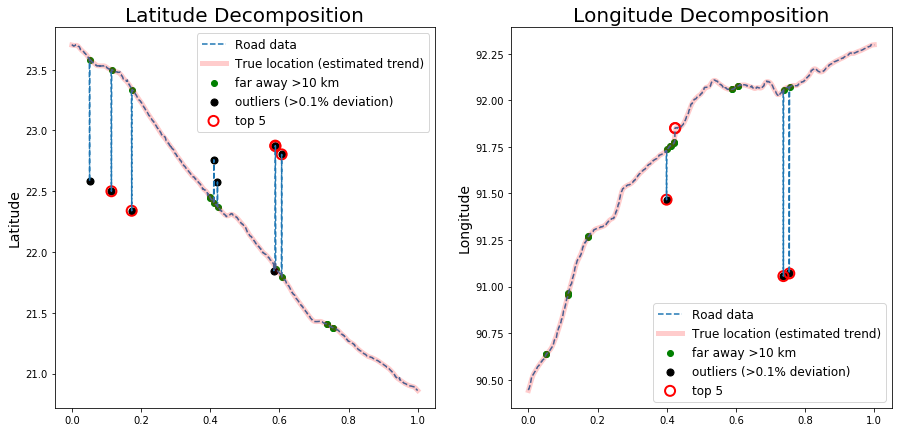

In [3]:
visual_check(df1)

## 2) Correct and re-visualize

1 iteration(s)
2 iteration(s)


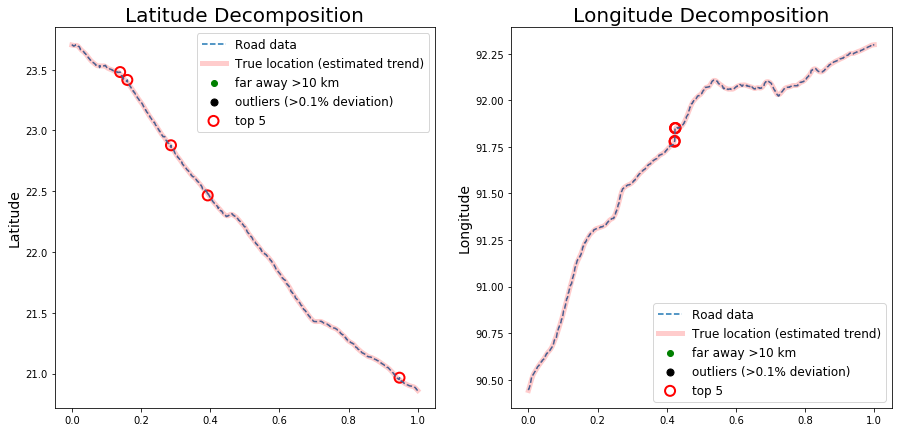

In [4]:
visual_check(smoothing(df1))

However, sometimes *local regression will also fail* to detect such points, if

    1) number of data points is not large (n < 50) and 2) outliers are way too far. (Such points are given high weigts, when the algorithm fits the regression.)

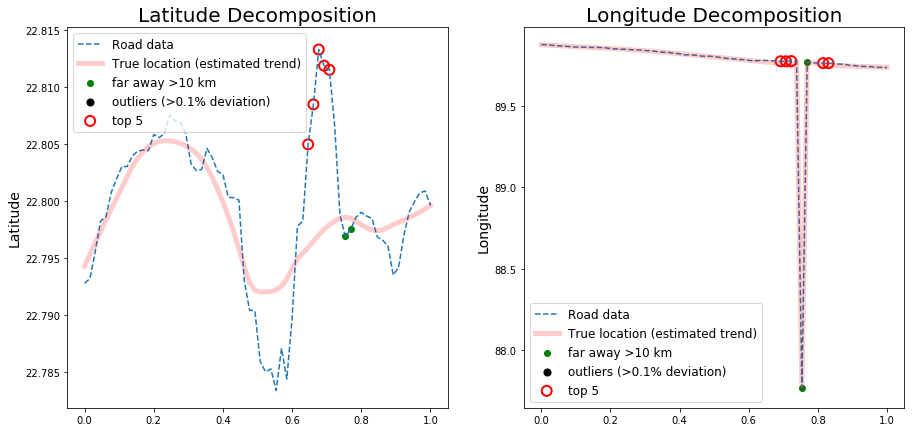

In [5]:
visual_check(df2)

    On the right panel (above), the trend line (pink line) fails to capture the point, and it should be detected by another algorithm (find out the point further than 10km.)

1 iteration(s)
2 iteration(s)


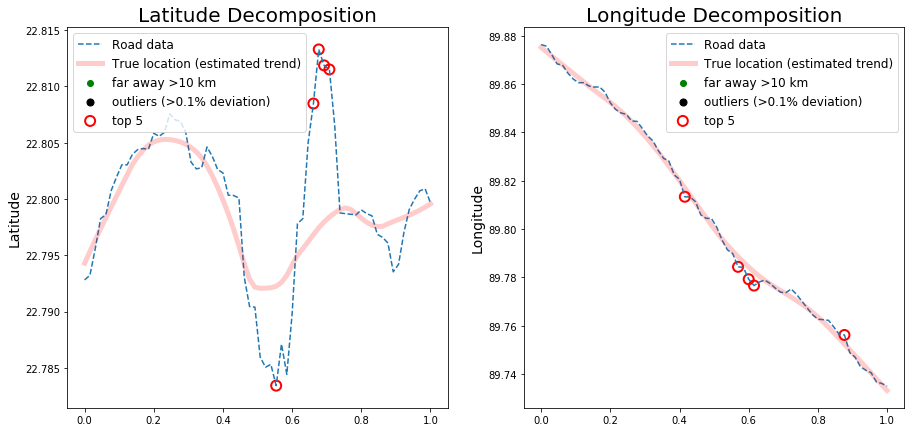

In [6]:
visual_check(smoothing(df2))

## 3. Test the robustness of the algorithm
#### Randomize (Mess up) the data on purpose, and see if it can re-correct again.

In [7]:
df_road = pd.read_csv("_roads2.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road[0], road, df_road[df_road['road'] == road]] for road in road_num],
                       columns = ['class', 'road', 'data_frame'])

### Test the algorithm by changing 2 parameters
#### - Fraction of data points to be randomized
#### - Extent of the randomization

1 iteration(s)


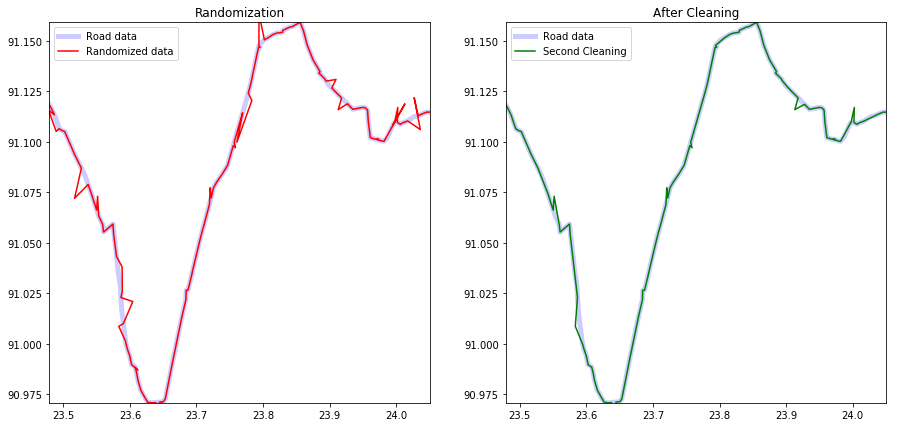

In [8]:
# 10% of data are randomized
randomize(df_road, road_num = 2)

1 iteration(s)


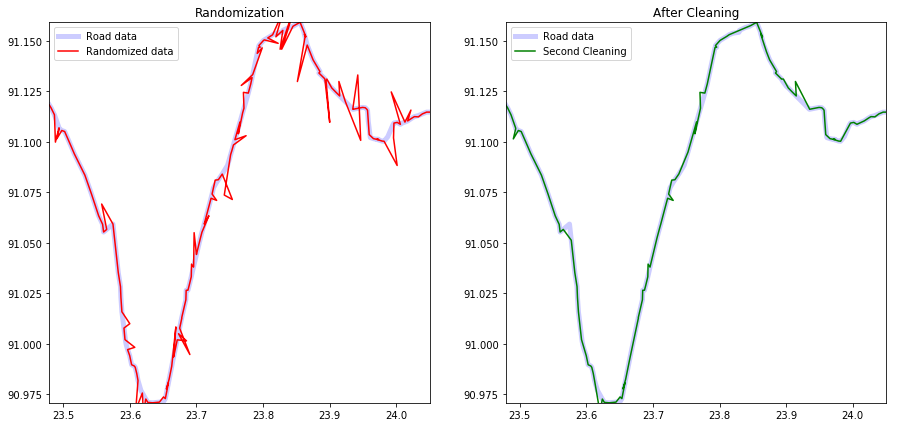

In [9]:
# increase the fraction of data to be randomized (10% → 20%)
randomize(df_road, road_num = 2, frac = 20)

1 iteration(s)


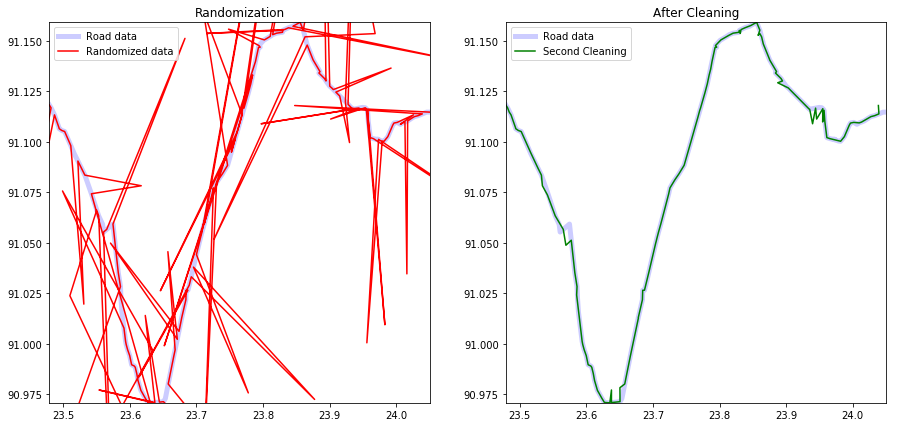

In [10]:
# increase the extent of randomization
randomize(df_road, road_num = 2, frac = 20, s = 0.1)

1 iteration(s)


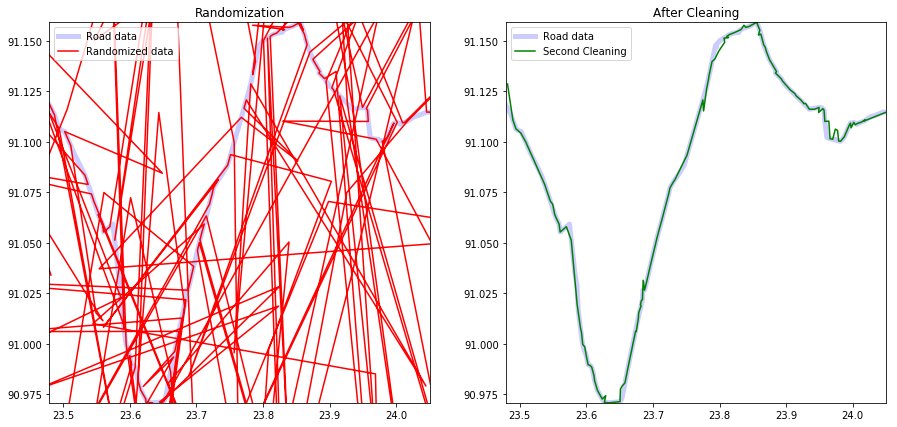

In [11]:
# 40% of data, double the extent of randomization
randomize(df_road, road_num = 2, frac = 40, s = 0.2)

#### The algorithm performs well, even though 40% of data are randomized!

## 4. Improve the algorithm by applying 'bagging' method

The local regression *must be complemented by one **other algorithm which calculates the absolute distance**.*
Because, *it fails to capture the 'true' trend when such ouliers are too extreme and/or number of data points are small.* (For example, road number 'Z7801')

However, this algorithm (checking the distance of every pairs) requires **a heavy computational expense.**
Therefore, here, **the bootstrap aggregation** (so called bagging) method is introduced to see whether it can improve the predictive performance.

In [12]:
df_road = pd.read_csv("_roads2_original.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road[0], road, df_road[df_road['road'] == road]] for road in road_num],
                       columns = ['class', 'road', 'data_frame'])

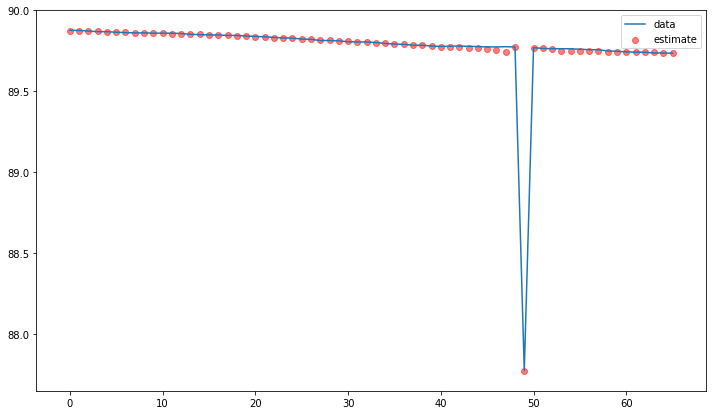

In [13]:
# Z7801
df = pd.DataFrame(df_road['data_frame'].iloc[785])[["lon", "lat"]]

cols  = ["lon", "lat"]
i = 0

y = df[cols[i]]
x = np.arange(len(y))

nbr = 20
f = nbr / len(df)
lowess = sm.nonparametric.lowess(y, x, frac = f)
yest2 = list(zip(*lowess))[1]
yest2 = np.array(yest2)

plt.figure(figsize = (12, 7))
plt.plot(x, y, label = "data")
plt.scatter(x, yest2, alpha = 0.5, color = "red", label = "estimate")
plt.legend()

In [14]:
# The road consist of only with 66 data points, and the outlier is too extreme.
len(df)
# Local regression has to depend on "distance-checking" algorithm.

66

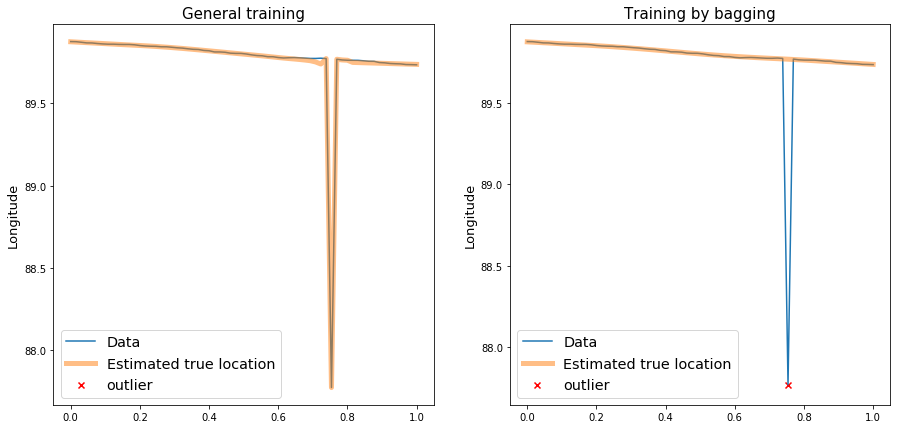

In [15]:
bagging(df_road, 785, 0)

### The outlier of the road "Z7801" is successfully detected on the right panel (which is not detected on the left), after applying the bagging method.